# This script contains
    1. Initial descriptive analysis
    2. Data aggregation, which is not written great, but very effective in memory.

In [1]:
import pandas as pd
import numpy as np

In [2]:
tr = pd.read_csv('./Data/train.csv')
te = pd.read_csv('./Data/test.csv')
sn = pd.read_csv('./Data/sample_submission.csv')

In [8]:
tr.head(1)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,68113152929,-1,FINANCIAL SERVICES,1000


In [4]:
te.head(1)

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,1,Friday,72503389714,1,SHOES,3002


# Descriptive analysis. All prints are in Russian

#### Сначала на целевую переменную

Всего категорий: 38
Помним, что 999 - это остальное


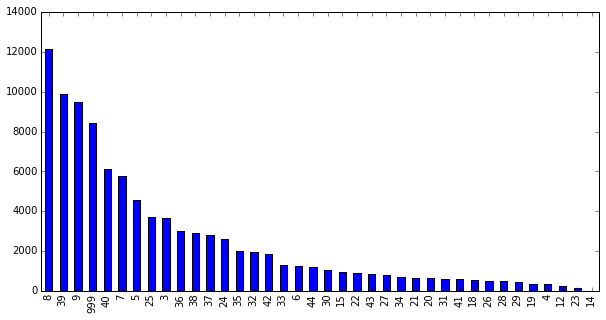

In [51]:
qq = tr.groupby('VisitNumber').TripType.first()
# print('Наиболее часто встречаюющиеся категории:\n',qq.value_counts()[:10])
print('Всего категорий:', qq.nunique())
print('Помним, что 999 - это остальное')
qq.value_counts().plot(kind = 'bar', figsize = (10,5))

In [27]:
print('Всего визитов одинаковое количество. В обучающей: {0}, в тестовой {1}'
      .format(tr.VisitNumber.nunique(), te.VisitNumber.nunique()))

Всего визитов одинаковое количество. В обучающей: 95674, в тестовой 95674


In [12]:
print('Всего видов товаров. В обучающей: {0}, в тестовой {1}.\nЧисло товаров, которых нет в обучающей выборке {2}, \
в тестовой {3}'
      .format(tr.Upc.nunique(), te.Upc.nunique(), 
              len(set(te.Upc.unique()).difference(set(tr.Upc.unique()))), 
              len(set(tr.Upc.unique()).difference(set(te.Upc.unique())))))
print('Популярные товары в обучающей выборке: \n', tr.Upc.value_counts().iloc[:5])
print()
print('В тестовой\n',te.Upc.value_counts().iloc[:5])
print('Число NaN в обучающей {0}, в тестовой {1}'.format(pd.isnull(tr.Upc).sum(), pd.isnull(te.Upc).sum() ))

Всего видов товаров. В обучающей: 97714, в тестовой 98147.
Число товаров, которых нет в обучающей выборке 26980, в тестовой 26547
Популярные товары в обучающей выборке: 
 4011           7657
60538862097    2501
7874235186     2067
7874235187     1883
4046           1652
dtype: int64

В тестовой
 4011           7558
60538862097    2433
7874235186     2073
7874235187     1901
4046           1665
dtype: int64
Число NaN в обучающей 4129, в тестовой 3986


In [45]:
print('Посмотрим на количество покупаемых товаров в обучающей и тестовой. Не должны заметить сильных различий. \
Особенно интересны 1 и -1. Пропорции очень очень похожи, спасибо Уолмарт\n')
print(tr.ScanCount.value_counts()[:5],'\n\n', te.ScanCount.value_counts()[:5] )

Посмотрим на количество покупаемых товаров в обучающей и тестовой. Не должны заметить сильных различий. Особенно интересны 1 и -1. Пропорции очень очень похожи, спасибо Уолмарт

 1    561489
 2     53002
-1     14394
 3      9445
 4      4536
dtype: int64 

  1    567311
 2     53483
-1     14629
 3      9457
 4      4586
dtype: int64


In [63]:
print('Пропорции топа различных категорий товаров тоже почти совпадают.\n')
print(tr.DepartmentDescription.value_counts()[:11], '\n\n', te.DepartmentDescription.value_counts()[:11])

Пропорции топа различных категорий товаров тоже почти совпадают.

GROCERY DRY GOODS           70402
DSD GROCERY                 68332
PRODUCE                     51115
DAIRY                       43820
PERSONAL CARE               41969
IMPULSE MERCHANDISE         28712
HOUSEHOLD CHEMICALS/SUPP    24880
PHARMACY OTC                23306
FROZEN FOODS                21101
HOUSEHOLD PAPER GOODS       16274
COMM BREAD                  15244
dtype: int64 

 GROCERY DRY GOODS           72335
DSD GROCERY                 68860
PRODUCE                     50928
DAIRY                       44824
PERSONAL CARE               41607
IMPULSE MERCHANDISE         28441
HOUSEHOLD CHEMICALS/SUPP    24602
PHARMACY OTC                23293
FROZEN FOODS                21890
COMM BREAD                  15688
HOUSEHOLD PAPER GOODS       15642
dtype: int64


In [64]:
print('Топ более узких категорий тоже совпадает примерно.\n')
print(tr.FinelineNumber.value_counts().iloc[:10], '\n\n', te.FinelineNumber.value_counts().iloc[:10])

Топ более узких категорий тоже совпадает примерно.

5501    8244
1508    5121
135     4538
808     4401
0       3837
9546    2997
1407    2848
4606    2753
115     2723
203     2639
dtype: int64 

 5501    8185
1508    5189
808     4478
135     4451
0       3705
1407    3029
9546    2987
4606    2716
115     2656
3004    2628
dtype: int64


In [65]:
print('Число категорий в обучающей выборке {0}, более узких категорий {1}'.format(tr.DepartmentDescription.nunique(), tr.FinelineNumber.nunique()))

Число категорий в обучающей выборке 68, более узких категорий 5195


# Data aggregation, highly unreadable code

In [6]:
def popular_in_classes(train, test, class_label, target_label, number_of_values):
    def take_popular(x, n, colname):
        nval = x[colname].nunique()
        if n > nval:
            n = nval
        return pd.DataFrame({colname: list(x[colname].value_counts().iloc[:n].index),
                             'rating': list(range(n))})
    popular_df = train.groupby(target_label).apply(lambda x: take_popular(x, number_of_values, class_label))
    def get_rating(x, colname):
        return pd.Series({colname+'_place': str(x['rating'].min()) + '_' + str(x[colname].iloc[0])})
    popular_df = (popular_df.reset_index(drop = True)
                     .groupby(class_label)
                     .apply(lambda x: get_rating(x, class_label)).reset_index())
    popular = [item for sublist in popular_df.values for item in sublist]
    popular_df.loc[:, class_label] = popular_df[class_label].apply(lambda x: class_label + '_' + str(x))
    popular_df.loc[:, class_label + '_place'] = popular_df[class_label+'_place'].apply(lambda x: class_label + '_'+str(x))
    popular_dict = dict(zip(popular_df[class_label], popular_df[class_label+'_place']))
    popular = list(set(popular).intersection(set(test[class_label].unique())))
    
    return popular, popular_dict

def get_scan_counts_per_category(tr, te, colname, num):
    pop_smth, rename_smth = popular_in_classes(tr, te, colname,'TripType', num)
    def get_scans_per_category(df,colname, popular, rename_dict):
        dummied = pd.get_dummies(df[df[colname].isin(popular)][[colname, 'VisitNumber']], columns = [colname]).rename(columns = rename_dict)
        sc = df[df[colname].isin(pop_smth)]['ScanCount']
        collist = list(dummied.columns)
        collist.remove('VisitNumber')
        dummied[collist] = dummied[collist].astype(np.int8)
        sc = sc.astype(np.int8)
        for i in range(len(collist)):
            dummied[collist[i]] = dummied[collist[i]]*sc
        return dummied
    dummied_train = get_scans_per_category(tr, colname, pop_smth, rename_smth)
    dummied_test = get_scans_per_category(te, colname, pop_smth, rename_smth)
    dummied_train = dummied_train.groupby('VisitNumber').sum().reset_index()
    dummied_test = dummied_test.groupby('VisitNumber').sum().reset_index()
    return dummied_train, dummied_test

def aggregate_data(x):
    return_dummy = int((x.ScanCount <0).any())
    all_return = int((x.ScanCount <0).all())
    na_exists = int(pd.isnull(x.Upc).any())
    one_return = int(x[x.ScanCount<0].shape == 1)
    
    to_series_dict = {'num_positions':x[x.ScanCount>0].shape[0],
                      'num_goods': x[x.ScanCount>0].ScanCount.sum(),
                      'return_dummy': return_dummy,
                      'num_cats': x.DepartmentDescription.nunique(),
                      'num_returns': x[x.ScanCount<0].shape[0],
                      'num_ones': x[x.ScanCount==1].shape[0],
                      'num_diff_q': x.ScanCount.nunique(),
                      'max_scans': x.ScanCount.max(),
                      'all_return': all_return,
                      'num_fineline': x.FinelineNumber.nunique(),
                      'na_exists': na_exists,
                      'num_rare_goods': x.rare_good.sum(),
                      'one_return': one_return,
                      'percent_ones': x[x.ScanCount == 1].shape[0]/x.shape[0], # Если ходит и покупает тут и там вещи
                      'all_different_deps': int(x.DepartmentDescription.nunique() == x.shape[0]), # Покупатель схватил самое необходимое из разных категорий
                      'all_different_fineline': int(x.FinelineNumber.nunique() == x.shape[0]),
                      'combos': (x[x.ScanCount!=-1].ScanCount.value_counts()>1).sum(), # Покупатель набирает товары по акции (типа купи это и это по сниженной цене), не знаю есть ли такое в уолмарте 
                      'only_one_good': int((x.shape[0]==1) & (x.ScanCount.iloc[0]>0)), # Одна покупка и не возврат
                      'only_fin_services': int((x.DepartmentDescription=="FINANCIAL SERVICES").all()), # Потому что категория сильно отличается от других и высоко стоит в РФ важности фичей
                      'only_one_dep': int(x[x.ScanCount>0].DepartmentDescription.nunique() == 1),
#                       'scancount_variance': x[x.ScanCount>0].ScanCount.std()
                      }
    return pd.Series(to_series_dict).astype(np.int8)

def merge_w_save_space(df1, df2):
    temp = pd.concat([df1.set_index('VisitNumber'), df2.set_index('VisitNumber')], axis = 1).fillna(0)
    temp.reset_index(inplace = True)
    cols = list(temp.columns)
    cols.remove('VisitNumber')
    temp[cols] = temp[cols].astype(np.int8)
    return temp

def get_pairs(x, colname, class_label, test=False):
    value_list = x[colname].astype(str).unique()
    value_list.sort()
    if not test:
        tt =x[class_label].iloc[0]
    else:
        tt = -1
    record_list = list()
    for i in range(len(value_list)-1):
        for j in range(i+1, len(value_list)):
            record_list.append([tt, str(value_list[i])+str(value_list[j])])
    return pd.DataFrame().from_records(record_list, columns = [class_label, '2'+colname])

In [7]:
from sklearn.preprocessing import LabelEncoder
popular_categories = {'Upc': 20,
                     'DepartmentDescription':15,
                     'FinelineNumber':20}

popular_pairs= {'2Upc': 20,
                '2DepartmentDescription':20,
                '2FinelineNumber':20}

temp = tr.Upc.append(te.Upc).value_counts()
tr['rare_good'] = 0
te['rare_good'] = 0
tr.loc[tr.Upc.isin(np.array(temp[temp<3].index)), 'rare_good'] = 1
te.loc[te.Upc.isin(np.array(temp[temp<3].index)), 'rare_good'] = 1

te_aggregates = te.groupby('VisitNumber').apply(aggregate_data).reset_index()
tr_aggregates = tr.groupby('VisitNumber').apply(aggregate_data).reset_index()
te_aggregates['ave_position'] = te_aggregates['num_goods'].div(te_aggregates['num_goods'])
tr_aggregates['ave_position'] = tr_aggregates['num_goods'].div(tr_aggregates['num_goods'])

te_aggregates_1 = te_aggregates.copy()
tr_aggregates_1 = tr_aggregates.copy()
for i in popular_categories:
    temp_train, temp_test = get_scan_counts_per_category(tr, te, i, popular_categories[i])
    te_aggregates_1 = merge_w_save_space(te_aggregates_1, temp_test)
    tr_aggregates_1 = merge_w_save_space(tr_aggregates_1, temp_train)
    
for i in popular_pairs:
    test_pairs = te.groupby('VisitNumber').apply(lambda x: get_pairs(x, i[1:], 'TripType', True))
    train_pairs = tr.groupby('VisitNumber').apply(lambda x: get_pairs(x, i[1:], 'TripType', False))
    test_pairs['ScanCount'] = np.int8(1)
    train_pairs['ScanCount'] = np.int8(1)
    temp_train, temp_test = get_scan_counts_per_category(train_pairs.reset_index(), test_pairs.reset_index(), i, popular_pairs[i])
    te_aggregates_1 = merge_w_save_space(te_aggregates_1, temp_test)
    tr_aggregates_1 = merge_w_save_space(tr_aggregates_1, temp_train)

tr_aggregates_1 = tr_aggregates_1.merge(tr[['VisitNumber', 'TripType']].drop_duplicates(), how = 'left', on = 'VisitNumber')
tr_aggregates_1 = tr_aggregates_1.merge(tr[['VisitNumber', 'Weekday']].drop_duplicates(), how = 'left', on = 'VisitNumber')
te_aggregates_1 = te_aggregates_1.merge(te[['VisitNumber', 'Weekday']].drop_duplicates(), how = 'left', on = 'VisitNumber')

le = LabelEncoder()
le.fit(tr_aggregates_1['Weekday'].append(te_aggregates_1['Weekday']))
tr_aggregates_1.loc[:, 'Weekday'] = le.transform(tr_aggregates_1['Weekday'])
te_aggregates_1.loc[:, 'Weekday'] = le.transform(te_aggregates_1['Weekday'])

In [8]:
tr_aggregates_1.to_pickle('./Data/tr_aggregates_2')
te_aggregates_1.to_pickle('./Data/te_aggregates_2')